In [10]:
import cv2
import json
from src.utils.func import (crop_center, read_image_as_numpyimage, 
    pipette_color, apply_pht, _convert_hough_segments_to_lines,
    group_lines)
from src.utils.const import ref_snooker_playfield
from src.utils.playfield_finder import PlayfieldFinder
from src.utils.points import Point
from src.utils.lines import Line
import numpy as np
from src.utils.plotting import display_img, plot_on_image
import src.config
from src.utils.metrics import iou, _reorder_pts
from src.utils.intersections import compute_intersections
from src.utils.annotations import transform_annotation
from pathlib import Path
import pandas as pd
from src.utils.annotations import PolygonAnnotation
import matplotlib.pyplot as plt

In [11]:
picname = 'pic_02_07_01'
pic = read_image_as_numpyimage(f'pics/{picname}.png', 'rgb') # pic_02_07_01.png   pic_05_18_01.png  pic_08_08_01.png pic_06_16_02.png
cropped_pic = crop_center(pic)

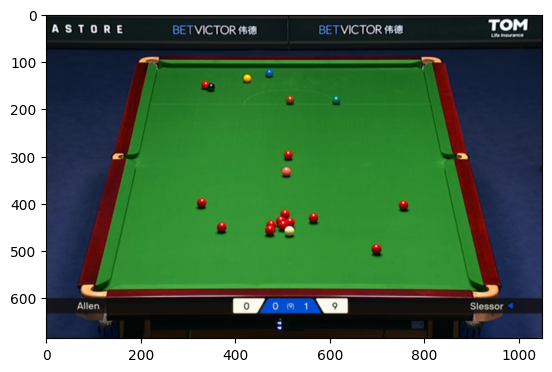

In [12]:
display_img(pic)

#### find playfield

In [13]:
finder = PlayfieldFinder(pic)

##### find internal bottom cushion

In [14]:
internal_top_cushion = finder.find_top_internal_cushion()
internal_top_cushion

y = 0.0 * x + 105.0

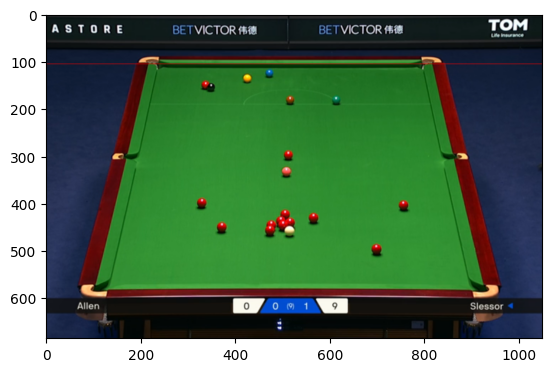

In [15]:
display_img(plot_on_image(pic, lines=[internal_top_cushion], line_thickness=1))

In [16]:
polygon_annp = PolygonAnnotation(root_dir='playfield_gt')
polygon_annp.concat_files()
polygon_annp.clean_annotations

[PolygonAnnotationData(points=[[21.56872416546001, 16.90290902353159], [80.42953337754462, 16.698480449194538], [90.76790489458021, 86.7665678463344], [11.091730982024973, 86.57973565561119]], image=ImageData(name='pic_01_04_01.png', width=1188, height=830)),
 PolygonAnnotationData(points=[[11.378165247222933, 88.5329812858996], [85.9932969153067, 89.12049904267802], [76.2709776548382, 19.046847013773085], [21.238598616368872, 18.85229448459021]], image=ImageData(name='pic_01_05_01.png', width=1265, height=832)),
 PolygonAnnotationData(points=[[9.303616193280698, 82.50957321968995], [89.90389669670242, 82.29571984435799], [78.77749070047128, 12.817305910691124], [19.57982803459666, 13.011858439874002]], image=ImageData(name='pic_01_06_01.png', width=1165, height=832)),
 PolygonAnnotationData(points=[[18.457356356528866, 17.879531838675813], [79.13189682445288, 17.677258971033293], [89.8920986617451, 85.42400098820333], [7.845487505997592, 84.24124513618678]], image=ImageData(name='pic_

In [8]:
root = Path('pics')
results = []
ious = []
pic_names = []
for file in sorted(root.glob('*.png')):
    pic = read_image_as_numpyimage(file, 'rgb')
    finder = PlayfieldFinder(pic)
    internal_bottom_cushion = None
    y_ref = None
    data = polygon_annp.filter_by_image(file.name)
    if data is None:
        print(file.name)
        
    else:
        points_gt = np.asarray(transform_annotation(pic, data.points))

        y_coords = points_gt[:, 1]
        y_ref = int(np.median(np.sort(y_coords)[:2]))

    try:
        internal_bottom_cushion = finder.find_top_internal_cushion()
        pts = internal_bottom_cushion.limit_to_img(pic)
        pic_copy = cv2.cvtColor(pic, cv2.COLOR_RGB2BGR)
        cv2.line(pic_copy, *pts, (255, 0, 0), 1)
        cv2.imwrite(f'bottom_line_tests/test_{file.stem}.png', pic_copy)
        
    except Exception as e:
        print(f'Error processing {file}: {e}')

    finally:
        results.append(
            {'pic_name': file.name, 
            'internal_bottom_cushion': internal_bottom_cushion, 
            'intercept_ref': y_ref,
            'intercept_pred': internal_bottom_cushion.intercept if internal_bottom_cushion is not None else None,
            }) 


pic_05_05_01.png
Error processing pics/pic_06_07_02.png: OpenCV(4.12.0) /io/opencv/modules/imgproc/src/convhull.cpp:143: error: (-215:Assertion failed) total >= 0 && (depth == CV_32F || depth == CV_32S) in function 'convexHull'

Error processing pics/pic_07_30_02.png: 'NoneType' object has no attribute 'limit_to_img'
Error processing pics/pic_07_34_02.png: bad operand type for unary -: 'NoneType'
Error processing pics/pic_07_36_02.png: bad operand type for unary -: 'NoneType'


In [9]:
df = pd.DataFrame(results)
df['diff']= df['intercept_ref'] - df['intercept_pred']
df['abs_diff']= np.abs(df['intercept_ref'] - df['intercept_pred'])

In [19]:
df.to_excel('top_cushion_results.xlsx', index=False)

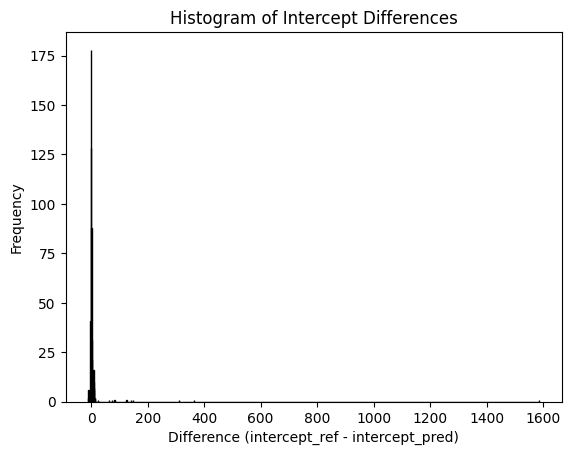

In [17]:
# Calculate bins based on binwidth=1
diff_clean = df['diff'].dropna()

min_val = diff_clean.min()
max_val = diff_clean.max()
bins = np.arange(min_val, max_val + 1, 1)  # binwidth = 1
plt.hist(diff_clean, bins=bins, edgecolor='black')
plt.xlabel('Difference (intercept_ref - intercept_pred)')
plt.ylabel('Frequency')
plt.title('Histogram of Intercept Differences')
plt.show()


In [18]:
df['diff'].median(), df['diff'].mean(),df['diff'].std()

(np.float64(0.0), np.float64(5.459834765509272), np.float64(68.26573774176184))

In [18]:
wrong_pics = pd.read_excel('/home/polymorvic/Desktop/zdjecia_do_poprawy.ods')[['col2']]

In [20]:
df

,pic_name,internal_bottom_cushion,intercept_ref,intercept_pred,diff,abs_diff
0,pic_01_02_01.png,y = 0.0 * x + 774.0,777.0,774.0,3.0,3.0
1,pic_01_03_01.png,y = 0.0 * x + 704.0,704.0,704.0,0.0,0.0
2,pic_01_04_01.png,y = 0.0 * x + 718.0,719.0,718.0,1.0,1.0
3,pic_01_05_01.png,y = 0.0 * x + 733.0,739.0,733.0,6.0,6.0
4,pic_01_06_01.png,y = 0.0 * x + 683.0,685.0,683.0,2.0,2.0
...,...,...,...,...,...,...
603,pic_09_51_02.png,y = 0.0 * x + 573.0,574.0,573.0,1.0,1.0
604,pic_09_52_01.png,y = 0.0 * x + 597.0,598.0,597.0,1.0,1.0
605,pic_09_53_01.png,y = 0.0 * x + 575.0,577.0,575.0,2.0,2.0
606,pic_09_55_01.png,y = 0.0 * x + 585.0,584.0,585.0,-1.0,1.0


<Axes: >

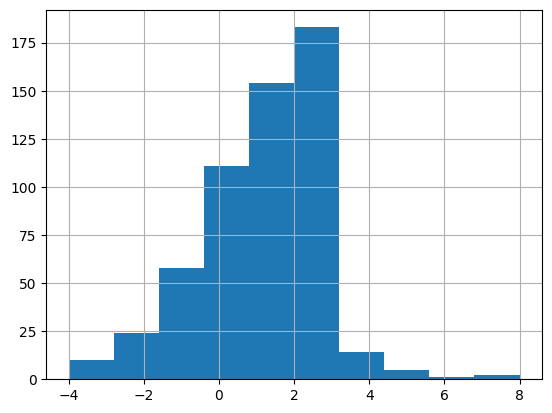

In [ ]:
ddf[~df['pic_name'].isin(wrong_pics['col2'])].sort_values(by='abs_diff', ascending=False)['diff'].hist()

<Axes: >

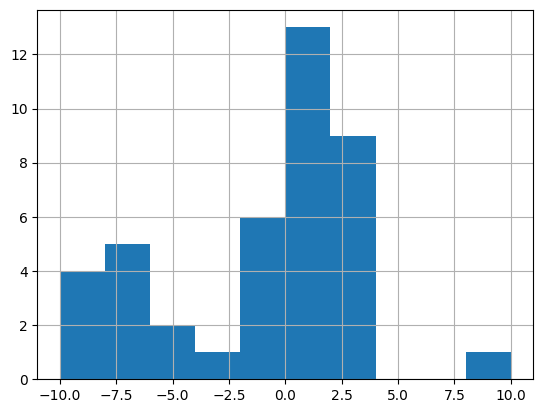

In [27]:
df[df['pic_name'].isin(wrong_pics['col2'])].sort_values(by='abs_diff', ascending=False)['diff'].hist()

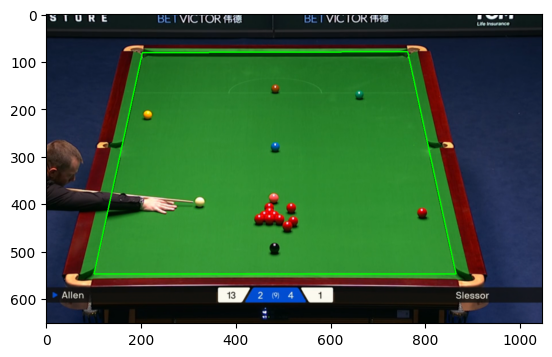

In [13]:
pic = read_image_as_numpyimage(f'pics/{picname}.png', 'rgb')
data = polygon_annp.filter_by_image('pic_07_13_01.png')
points_gt = np.asarray(transform_annotation(pic, data.points))
display_img(plot_on_image(pic, polygons=[transform_annotation(pic, data.points)]))

pic = read_image_as_numpyimage(f'pics/{picname}.png', 'rgb')

In [22]:
transform_annotation(pic, data.points)

[Point(91.79939472546474, 647.2434608733248),
 Point(1034.6517509727623, 648.6984435797665),
 Point(909.9885970600949, 74.13343060959794),
 Point(221.12202766969295, 74.04507133592737)]